1/1 [==============================] - 1s 677ms/step
Predicted: [('n03450230', 'gown', 0.19088534), ('n03534580', 'hoopskirt', 0.07605627), ('n03424325', 'gasmask', 0.054620344)]


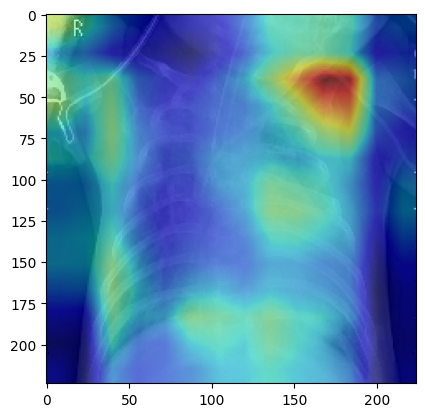

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import cv2


def get_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Choose an image from your dataset
img_path = '/content/sample_data/person1_virus_6.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the predictions for the image
preds = model.predict(x)
decoded_preds = decode_predictions(preds, top=3)[0]
print('Predicted:', decoded_preds)

# Choose the layer name from which you want to compute Grad-CAM
layer_name = 'block5_conv3'

# Get Grad-CAM heatmap
heatmap = get_grad_cam(model, x, layer_name)

# Overlay heatmap on the original image
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.show()
